In [1]:
import polars as pl

MalwareDataset = pl.read_csv(
    "../data/MalwareData.csv",
    separator='|',
    schema_overrides={
        "ImageBase": pl.UInt64 # Use unsigned 64-bit integer
    }
)

In [2]:
import numpy as np
import sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection

In [3]:
MalwareDataset_drop = MalwareDataset.drop(["Name", "md5", "legitimate"]) # legitimate is target
X = MalwareDataset_drop

In [4]:
y = MalwareDataset["legitimate"]

## Selecting features

In [5]:
# ExtraTreesClassifier
FeatSelect = ExtraTreesClassifier().fit(X, y)
Model = SelectFromModel(FeatSelect, prefit=True)
feature_idx = Model.get_support()
feature_name = X[feature_idx].columns

In [6]:
X = Model.transform(X)

/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [7]:
X = pl.DataFrame(X)
X.columns = feature_name

## Ada Boost

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate
import optuna

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [10]:
class ObjectiveABC:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __call__(self, trial):
        params = {
            "algorithm": trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"]),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-0)
        }

        model = AdaBoostClassifier(**params)
        scores = cross_validate(
            model,
            X=self.X,
            y=self.y,
            cv=5,
            n_jobs=-1
        )
        return scores["test_score"].mean()

In [11]:
objective = ObjectiveABC(X_train, y_train)
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=60)

[I 2024-10-08 01:46:08,794] A new study created in memory with name: no-name-6e8f5290-e730-41ed-a251-629329c66a36
/tmp/ipykernel_34516/435131687.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-0)
/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/rytst/dev/ml_for_security

In [12]:
print(study.best_params)

{'algorithm': 'SAMME.R', 'learning_rate': 0.3980021749132331}


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

model = AdaBoostClassifier(**study.best_params)

model.fit(X_train, y_train)

pred = model.predict(X_test)

print("Accuracy: {}".format(accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9860338433008808
[[23897   183]
 [  299 10133]]


In [14]:
feat_importance = pl.DataFrame({
    "feature": X.columns,
    "feature importance": model.feature_importances_
}).sort("feature importance")

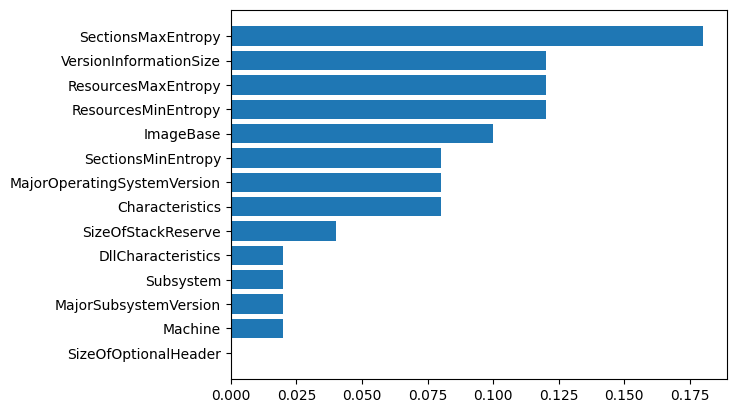

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.barh(feat_importance["feature"], feat_importance["feature importance"], align='center')
plt.show()